## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import sklearn.metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
import pickle


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.4 MB/s 


In [2]:
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import mediapipe
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

## Steps:
1- create train set:
  - for loop on each image -> extract landmarks -> **features** using dlib AND Convert images to (Yaw, Pitch, Roll) using formula (from Asmaa) -> **label**


- Read images dataset , processed dataset
<!-- - Use dlib -> extract keypoint -> train  (68 points/features) -->
- Feature engineering on keypoints
- Train models 
- output -> x, y, x, Yaw, pitch, Roll


## Read Dataset

In [61]:
data = pd.read_csv('/content/drive/MyDrive/ITI/Projects/Gaze Estimation - ml1 project/fatima_features.csv')

In [17]:
data

,Unnamed: 0,ID,F1,F2,F3,F4,F5,F6,F7,F8,...,F930,F931,F932,F933,F934,F935,F936,Pitch,Yaw,Roll
0,0,image00002.jpg,0.485651,0.686890,0.489194,0.639721,0.489802,0.647256,0.479730,0.562529,...,0.492813,0.541429,0.500371,0.665668,0.471336,0.676091,0.464005,-0.399231,0.018227,0.085676
1,1,image00004.jpg,0.441502,0.642091,0.417273,0.592251,0.448839,0.610546,0.435994,0.545069,...,0.511724,0.500658,0.514913,0.584451,0.500244,0.594060,0.495387,0.470065,1.189533,0.300959
2,2,image00006.jpg,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,0.311064,0.745973,...,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798,-0.184650,0.881137,-0.236852
3,3,image00008.jpg,0.503922,0.694309,0.469521,0.653913,0.489504,0.658751,0.444433,0.590285,...,0.510606,0.490586,0.518652,0.595615,0.455611,0.602670,0.444623,-0.175379,0.299208,-0.373374
4,4,image00013.jpg,0.510238,0.669038,0.492729,0.604797,0.499756,0.624468,0.467368,0.542362,...,0.488652,0.505667,0.492681,0.602484,0.452699,0.611310,0.448576,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,1848,image04345.jpg,0.515443,0.683951,0.532837,0.625785,0.518815,0.639885,0.511650,0.560010,...,0.503230,0.540073,0.508401,0.629060,0.479723,0.635765,0.474628,-0.306358,-0.283822,0.038554
1849,1849,image04348.jpg,0.543907,0.689844,0.565286,0.635285,0.549289,0.646834,0.545585,0.562769,...,0.500254,0.574974,0.506460,0.659800,0.479817,0.667754,0.470887,-0.367547,-0.429723,0.122791
1850,1850,image04356.jpg,0.586373,0.680103,0.604407,0.627700,0.593793,0.645848,0.602947,0.568153,...,0.539478,0.648903,0.541426,0.734017,0.547668,0.743284,0.540139,-0.156035,0.567114,-0.108536
1851,1851,image04358.jpg,0.491617,0.692910,0.500626,0.637631,0.497282,0.649833,0.490064,0.559349,...,0.496594,0.550279,0.502602,0.673963,0.481876,0.684592,0.474287,-0.197102,-0.070430,0.105118


## EDA
- Find duplicates
- Find Nulls


No duplicates in the dataset

In [18]:
data.duplicated().sum()

0

dataset statistic info

In [19]:
data.describe()

,Unnamed: 0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F930,F931,F932,F933,F934,F935,F936,Pitch,Yaw,Roll
count,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,...,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000
mean,926.000000,0.505036,0.666149,0.503698,0.611075,0.504510,0.627596,0.490213,0.550968,0.503416,...,0.503258,0.530948,0.507431,0.621081,0.485716,0.629547,0.478221,-0.095366,0.013611,-0.033167
std,535.059343,0.041261,0.028346,0.053271,0.029041,0.037840,0.024675,0.044587,0.023908,0.054824,...,0.023010,0.033922,0.022426,0.047496,0.038984,0.050135,0.041212,0.549292,0.580266,0.649282
min,0.000000,0.256906,0.179093,0.227159,0.144636,0.249772,0.152404,0.222207,0.100594,0.223030,...,0.055864,0.266672,0.060640,0.304541,0.032022,0.294275,0.024076,-12.457202,-6.130066,-16.969362
25%,463.000000,0.482141,0.652247,0.469521,0.598221,0.481937,0.617026,0.460069,0.540801,0.466724,...,0.491350,0.514206,0.496217,0.593103,0.463229,0.601160,0.454632,-0.246453,-0.256714,-0.160274
50%,926.000000,0.505162,0.668768,0.501536,0.614621,0.503587,0.629840,0.485371,0.552197,0.501211,...,0.502106,0.532342,0.506317,0.626023,0.485355,0.635011,0.477745,-0.123371,0.019403,-0.017463
75%,1389.000000,0.526248,0.682794,0.537543,0.627792,0.525717,0.641242,0.516599,0.562998,0.538674,...,0.513950,0.546662,0.517966,0.650143,0.506548,0.660787,0.499799,0.028133,0.305791,0.126460
max,1852.000000,0.928491,0.799190,0.929157,0.776498,0.923774,0.782066,0.901552,0.745973,0.926027,...,0.720868,0.908686,0.723342,0.990572,0.741343,0.998658,0.750775,15.598820,3.277500,2.166107


No null are found

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Columns: 941 entries, Unnamed: 0 to Roll
dtypes: float64(939), int64(1), object(1)
memory usage: 13.3+ MB


---------------------------------------------------

##  Data Preprocessing
*   Normalize data using subtract from nose point (x2, y2) /minmax, robust, standarization
*   apply pca on all features
*   apply pca on each keypoint components(x,y)
*   use models feature importance feature
*   choose features manually according to imporance

1- remove unneeded cols 

In [21]:
n_keypoints = 468
n_features = n_keypoints * 2
n_labels = 3   

In [62]:
data.drop(['Unnamed: 0', 'ID'], axis=1, inplace=True)
# data.drop(['image'], axis=1, inplace=True)

In [63]:
data.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F930,F931,F932,F933,F934,F935,F936,Pitch,Yaw,Roll
0,0.485651,0.686890,0.489194,0.639721,0.489802,0.647256,0.479730,0.562529,0.490558,0.621213,...,0.492813,0.541429,0.500371,0.665668,0.471336,0.676091,0.464005,-0.399231,0.018227,0.085676
1,0.441502,0.642091,0.417273,0.592251,0.448839,0.610546,0.435994,0.545069,0.415757,0.576966,...,0.511724,0.500658,0.514913,0.584451,0.500244,0.594060,0.495387,0.470065,1.189533,0.300959
2,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,0.311064,0.745973,0.321459,0.767816,...,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798,-0.184650,0.881137,-0.236852
3,0.503922,0.694309,0.469521,0.653913,0.489504,0.658751,0.444433,0.590285,0.461756,0.637613,...,0.510606,0.490586,0.518652,0.595615,0.455611,0.602670,0.444623,-0.175379,0.299208,-0.373374
4,0.510238,0.669038,0.492729,0.604797,0.499756,0.624468,0.467368,0.542362,0.488200,0.584701,...,0.488652,0.505667,0.492681,0.602484,0.452699,0.611310,0.448576,-0.026812,0.011965,-0.220662


2- normalize around nose keypoint -> x2, y2

In [26]:
# centered_data = data.copy()

In [27]:
# def center_keypoints(df):
#   for i in range(1, n_features + 1):
#     feature = 'F' + str(i)

#     if i % 2 != 0:
#       df[feature] = df[feature] - data['F3']
    
#     else:
#       df[feature] = df[feature] - data['F4']


In [28]:
# center_keypoints(centered_data)

In [29]:
# centered_data.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F930,F931,F932,F933,F934,F935,F936,Pitch,Yaw,Roll
0,-0.003543,0.047169,0.0,0.0,0.000608,0.007535,-0.009464,-0.077192,0.001364,-0.018508,...,-0.146908,0.052235,-0.139350,0.176474,-0.168385,0.186897,-0.175716,-0.399231,0.018227,0.085676
1,0.024229,0.049840,0.0,0.0,0.031566,0.018295,0.018721,-0.047182,-0.001516,-0.015286,...,-0.080527,0.083385,-0.077338,0.167178,-0.092007,0.176787,-0.096864,0.470065,1.189533,0.300959
2,-0.003530,0.022692,0.0,0.0,-0.003012,0.005568,-0.010264,-0.030525,0.000131,-0.008681,...,-0.055630,0.007312,-0.053156,0.052077,-0.063427,0.056315,-0.066700,-0.184650,0.881137,-0.236852
3,0.034401,0.040395,0.0,0.0,0.019983,0.004837,-0.025088,-0.063628,-0.007765,-0.016300,...,-0.143307,0.021064,-0.135261,0.126094,-0.198303,0.133149,-0.209290,-0.175379,0.299208,-0.373374
4,0.017510,0.064241,0.0,0.0,0.007027,0.019671,-0.025361,-0.062435,-0.004529,-0.020096,...,-0.116145,0.012938,-0.112116,0.109755,-0.152098,0.118581,-0.156221,-0.026812,0.011965,-0.220662


Normalize data

In [30]:
# min_max_data = pd.DataFrame(MinMaxScaler().fit_transform(centered_data), columns=centered_data.columns)
# data = min_max_data

In [31]:
data

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F930,F931,F932,F933,F934,F935,F936,Pitch,Yaw,Roll
0,0.455298,0.617747,0.0,0.0,0.521017,0.405172,0.520894,0.243454,0.587228,0.223812,...,0.276769,0.663772,0.273951,0.717219,0.289235,0.719820,0.298487,0.429782,0.653548,0.891279
1,0.639344,0.634314,0.0,0.0,0.776136,0.528854,0.726995,0.411119,0.514897,0.294199,...,0.467972,0.775543,0.462742,0.697300,0.477185,0.699352,0.480228,0.460766,0.778055,0.902529
2,0.455385,0.465921,0.0,0.0,0.491184,0.382561,0.515045,0.504183,0.556266,0.438459,...,0.539684,0.502583,0.536363,0.450670,0.547514,0.455430,0.549751,0.437430,0.745273,0.874424
3,0.706752,0.575731,0.0,0.0,0.680676,0.374161,0.406644,0.319234,0.357969,0.272034,...,0.287142,0.551930,0.286398,0.609269,0.215615,0.610996,0.221106,0.437761,0.683415,0.867289
4,0.594816,0.723640,0.0,0.0,0.573912,0.544673,0.404650,0.325903,0.439247,0.189124,...,0.365378,0.522770,0.356861,0.574258,0.329315,0.581500,0.343421,0.443056,0.652882,0.875270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.363513,0.685960,0.0,0.0,0.400453,0.480638,0.435174,0.307243,0.615901,0.228636,...,0.346917,0.502313,0.340827,0.545265,0.344169,0.549809,0.355094,0.433092,0.621441,0.888816
1849,0.337101,0.663588,0.0,0.0,0.384172,0.451315,0.446038,0.269578,0.633502,0.208435,...,0.310982,0.511107,0.305994,0.541601,0.321021,0.548875,0.324575,0.430911,0.605932,0.893218
1850,0.359272,0.650206,0.0,0.0,0.428536,0.527165,0.579423,0.342036,0.683179,0.250796,...,0.445805,0.636002,0.435535,0.616803,0.506652,0.622593,0.501668,0.438450,0.711893,0.881130
1851,0.419077,0.668055,0.0,0.0,0.488450,0.458818,0.512868,0.237367,0.623081,0.185865,...,0.293680,0.654508,0.287106,0.710497,0.320317,0.713887,0.327003,0.436986,0.644124,0.892295


-----------------------------------------

## Split data into train and test sets

In [64]:
# label consists of 3 parts for each observation
x = data.iloc[:, :n_features]
y = data.iloc[:, -n_labels:]
print('x shape: ', x.shape)
print('y shape: ', y.shape)

x shape:  (1853, 936)
y shape:  (1853, 3)


In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [66]:
# train, validate, test = np.split(data.sample(frac=1, random_state=1), [int(.6*len(data)), int(.8*len(data))])

In [67]:
print(f'x_train: {x_train.shape}       ,       y_train: {y_train.shape}')
# print(validate.shape)
print(f'x_test:  {x_test.shape}        ,       y_test:  {y_test.shape}')


x_train: (1482, 936)       ,       y_train: (1482, 3)
x_test:  (371, 936)        ,       y_test:  (371, 3)


-------------------------------------------------------------

## Model training
#### Training different models on our dataset

We'll train six models:
- BayesianRidge regressor       ***done***  
- DecisionTreeRegressor  ***done***
- RandomForestRegressor ***done***
- GradientBoostingRegressor
- AdaBoostRegressor
- knn                            ***done***

### 1- Use cross validation to choose best model 

In [35]:
def cross_val_repeated(model, x_train, y_train):
  # define the evaluation procedure
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

  # evaluate the model and collect the scores
  n_scores = cross_val_score(model, x_train, y_train, scoring='r2', cv=cv, n_jobs=-1)

  # # force the scores to be positive
  n_scores = np.absolute(n_scores)

  return np.mean(n_scores)

In [130]:
def cross_val(x_train, y_train):
  cv_scores_dict = {}
# Tree Models
  rf_model = RandomForestRegressor(n_estimators = 3, max_features = 'sqrt', max_depth = 5, random_state = 18)
  cv_scores_dict['RandomForestRegressor'] = cross_val_repeated(rf_model, x_train, y_train)

  # KNN Model
  knn_model = KNeighborsRegressor(5,leaf_size=15, weights='uniform')       
  cv_scores_dict['KNN_uniform'] = cross_val_repeated(knn_model, x_train, y_train)

  # KNN Model
  knn_model = KNeighborsRegressor(5, leaf_size=15, weights='distance')       
  cv_scores_dict['KNN_distance'] = cross_val_repeated(knn_model, x_train, y_train)

  return cv_scores_dict

In [68]:
cross_val(x_train, y_train['Yaw'])

{'KNN_distance': 0.8458124358249436,
 'KNN_uniform': 0.8625220174458605,
 'RandomForestRegressor': 0.7874434077083823}

In [70]:
cross_val(x_train, y_train['Pitch'])

{'KNN_distance': 0.5090267797583362,
 'KNN_uniform': 0.43095149059910903,
 'RandomForestRegressor': 0.5111953524685512}

In [69]:
cross_val(x_train, y_train['Roll'])

{'KNN_distance': 0.5802248340986641,
 'KNN_uniform': 0.5402873922262568,
 'RandomForestRegressor': 0.8658507748947087}

In [131]:
cross_val(x_train, y_train)

{'KNN_distance': 0.5413039881483053,
 'KNN_uniform': 0.47448437867903237,
 'RandomForestRegressor': 0.9499490401796599}

#### conclusion: 
KNN uniform performs the best with normalized data!! <br>
random forest performs better without normalization 

----------------------------------------------------

### Grid search for best hyper-parameters

model 1 -> no normalization

model 2 -> pipeline (normalizer, model)

In [ ]:
# #########
# knn_pipe = Pipeline([('mms', MinMaxScaler()), ('knn', neighboKNeighborsClassifier()rs.KNeighborsRegressor())])

In [132]:
def show3D(searcher, grid_param_1, grid_param_2, name_param_1, name_param_2, rot=0):
    scores_mean = searcher.cv_results_['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1), len(grid_param_2)).T

    print('Best params = {}'.format(searcher.best_params_))
    print('Best score = {}'.format(scores_mean.max()))

    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

    ax.tick_params(axis='x', rotation=rot)
    ax.set_title('Grid Search Scores')
    ax.set_xlabel(name_param_1)
    ax.set_ylabel('CV score')
    ax.legend(loc='best')
    ax.grid('on')

In [133]:
def gs_knn(x_train, y_train):
  knn_model = KNeighborsRegressor()       
  weights = ['uniform', 'distance']
  n_neighbors = list(range(2,25))
  leaf_size =  [15]
  params = [{'n_neighbors': n_neighbors,
          'weights': weights,
          'leaf_size': leaf_size}]

  knn_gs = GridSearchCV(knn_model, params, scoring='r2')

  knn_gs.fit(x_train, y_train)

  show3D(knn_gs, n_neighbors, weights,  'n_neighbors', 'weights', 80)


Best params = {'leaf_size': 15, 'n_neighbors': 23, 'weights': 'uniform'}
Best score = 0.5888618310591311


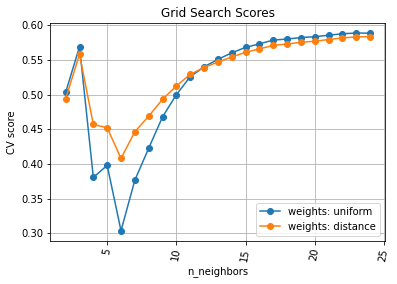

In [137]:
gs_knn(x_train, y_train)

Best params = {'leaf_size': 15, 'n_neighbors': 24, 'weights': 'uniform'}
Best score = 0.48235089539340403


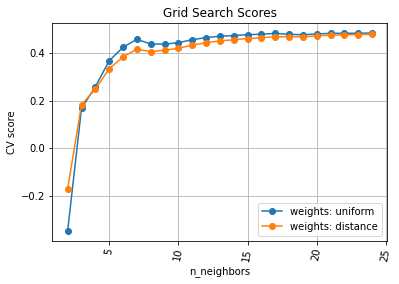

In [ ]:
gs_knn(x_train, y_train['pitch'])

Best params = {'leaf_size': 15, 'n_neighbors': 17, 'weights': 'uniform'}
Best score = 0.6330417556189529


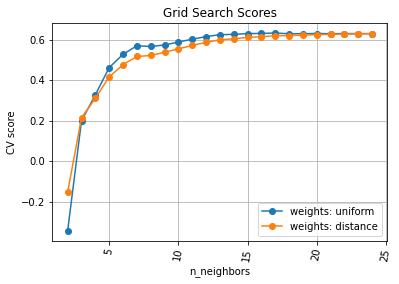

In [ ]:
gs_knn(x_train, y_train['roll'])

------------------------------------------------------

### Train random forest

In [126]:
def apply_random_forest(x_train, y_train, x_test, y_test):
  rf = RandomForestRegressor(bootstrap= True, max_depth= None, max_features= 'sqrt', min_samples_leaf= 4, min_samples_split= 5, n_estimators= 5)
  rf.fit(x_train, y_train)
  
  print(rf.score(x_test, y_test))
  return rf

In [96]:
apply_random_forest(x_train, y_train['Yaw'],  x_test, y_test['Yaw'])

0.9134040063373523


RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=3)

In [95]:
apply_random_forest(x_train, y_train['Pitch'],  x_test, y_test['Pitch'])

0.4231830652644816


RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=3)

In [94]:
apply_random_forest(x_train, y_train['Roll'],  x_test, y_test['Roll'])

-0.7326914786737546


RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=3)

In [127]:
multi_label_rf = apply_random_forest(x_train, y_train,  x_test, y_test)

0.6396484417873979


- Dump random forest model


In [123]:
with open('/content/drive/MyDrive/ITI/Projects/Gaze Estimation - ml1 project/multi_label_rf_4.pkl', 'wb') as file:
        pickle.dump(multi_label_rf, file)

-------------------------------------------------

### Train KNN with best params

knn for yaw

In [128]:
def apply_knn(x_train, y_train, x_test, y_test, n_neighbors):
  knn_model = KNeighborsRegressor(n_neighbors=n_neighbors, leaf_size=15).fit(x_train, y_train)
  score_knn = knn_model.score(x_test, y_test)
  print(score_knn)
  return knn_model

In [129]:
apply_knn(x_train, y_train['Yaw'], x_test, y_test['Yaw'], 9)

0.9232404511594925


KNeighborsRegressor(leaf_size=15, n_neighbors=9)

In [51]:
apply_knn(x_train, y_train['Pitch'], x_test, y_test['Pitch'], 60)

0.5744664760933924


KNeighborsRegressor(leaf_size=15, n_neighbors=60)

In [52]:
apply_knn(x_train, y_train['Roll'], x_test, y_test['Roll'], 10)

0.40464472828372655


KNeighborsRegressor(leaf_size=15, n_neighbors=10)

In [142]:
multi_label_knn = apply_knn(x_train, y_train, x_test, y_test, 17)

0.779356695810694


In [141]:
with open('/content/drive/MyDrive/ITI/Projects/Gaze Estimation - ml1 project/multi_label_knn_3.pkl', 'wb') as file:
        pickle.dump(multi_label_knn, file)

----------------------------------------------------

### Train SVR

In [152]:
len(y_train.shape)

2

In [168]:
def apply_svr(x_train, y_train, x_test, y_test, gamma=0.1, c=1):
  if len(y_train.shape) > 1:
    model = MultiOutputRegressor(SVR(gamma= gamma, C=c)).fit(x_train, y_train)
  else:
    model = SVR(gamma= gamma).fit(x_train, y_train)
  score_svr = model.score(x_test, y_test)
  print(score_svr)
  return model

In [155]:
apply_svr(x_train, y_train['Yaw'], x_test, y_test['Yaw'], 1, 1)

0.9282267766209242


In [95]:
apply_svr(x_train, y_train['pitch'], x_test, y_test['pitch'], 1, 1)

-6.7455299019474575


In [104]:
apply_svr(x_train, y_train['roll'], x_test, y_test['roll'])

-1.250731541873468


In [195]:
multi_label_svr = apply_svr(x_train, y_train, x_test, y_test, 0.07, 1)

0.83971455971573


In [196]:
with open('/content/drive/MyDrive/ITI/Projects/Gaze Estimation - ml1 project/multi_label_svr_5.pkl', 'wb') as file:
        pickle.dump(multi_label_svr, file)

With pca

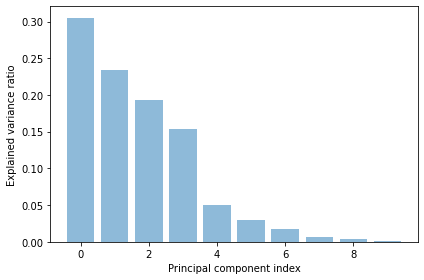

In [204]:
pca_model = PCA(10)
pca_train = pca_model.fit_transform(x_train)
pca_test = pca_model.transform(x_test)

exp_var_pca = pca_model.explained_variance_ratio_
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.tight_layout()
plt.show()

only 5 component 

Best params = {'leaf_size': 15, 'n_neighbors': 21, 'weights': 'uniform'}
Best score = 0.8852729575095168


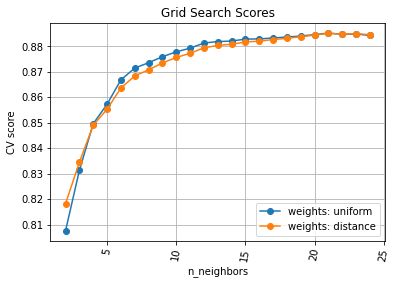

In [ ]:
gs_knn(pca_train, y_train['yaw'])

Best params = {'leaf_size': 15, 'n_neighbors': 24, 'weights': 'uniform'}
Best score = 0.46851609326767124


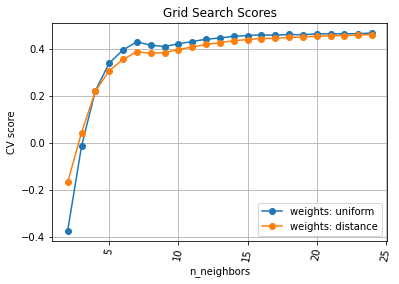

In [ ]:
gs_knn(pca_train, y_train['pitch'])

Best params = {'leaf_size': 15, 'n_neighbors': 23, 'weights': 'uniform'}
Best score = 0.5887988731008023


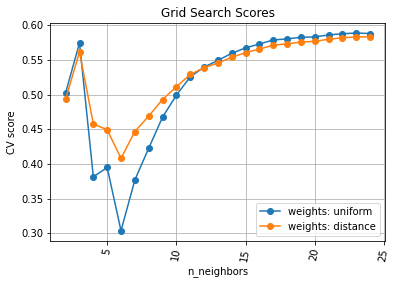

In [205]:
gs_knn(pca_train, y_train)

In [206]:
apply_knn(pca_train, y_train, pca_test, y_test, 17)

0.7788710673785589


KNeighborsRegressor(leaf_size=15, n_neighbors=17)

apply_knn(pca_train, y_train['roll'], pca_test, y_test['roll'], 10)



---



---



## Model Testing: Apply on video

In [143]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [198]:
# Load pretrained model
pkl_filename='/content/drive/MyDrive/ITI/Projects/Gaze Estimation - ml1 project/multi_label_svr_5.pkl'
with open(pkl_filename, 'rb') as file:
    pretrained_model = pickle.load(file)

In [199]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
mp_drawing_styles = mp.solutions.drawing_styles


In [202]:
import matplotlib.pyplot as plt
cap = cv2.VideoCapture('/content/drive/MyDrive/ITI/Projects/Gaze Estimation - ml1 project/trial.mp4')
i = 0
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# initialize the FourCC and a video writer object
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')   
out = cv2.VideoWriter('multi_label_svr_output_5_modified.avi', fourcc, fps, (frame_width, frame_height))
 
while cap.isOpened():
    ret, image = cap.read()

    if not ret:
      break

    # Flip the image horizontally for a later selfie-view display
    # Also convert the color space from BGR to RGB
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

    # To improve performance
    image.flags.writeable = False
    
    # Get the result
    results = face_mesh.process(image)
    
    # To improve performance
    image.flags.writeable = True
    
    # Convert the color space from RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
 
    # for landmark in face.landmark:
    img_h, img_w, img_c = image.shape
    face_3d = []
    face_2d = []

    if results.multi_face_landmarks != None:
        for face_landmarks in results.multi_face_landmarks:
            featuers = []
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx == 1:
                    nose_2d = (lm.x * img_w, lm.y * img_h)
                    nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                featuers.append(lm.x)
                featuers.append(lm.y)

            # Apply our model
            nose_pt = (int(nose_2d[0]), int(nose_2d[1]))
            featuers = np.array(featuers).reshape(1,-1)
            y_pred = pretrained_model.predict(featuers)
        
            pitch = y_pred[0][0]
            yaw = y_pred[0][1]
            roll = y_pred[0][2]
            image = draw_axis(image,pitch,yaw,roll,nose_pt[0],nose_pt[1])

            # Add the text on the image
            cv2.putText(image, "Yaw: " + str(np.round(yaw,2)), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.putText(image, "Pitch: " + str(np.round(pitch,2)), (500, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.putText(image, "Roll: " + str(np.round(roll,2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
       
    out.write(image)

    if cv2.waitKey(20) == ord('q'):
        break

    i+=1

cv2.destroyAllWindows()
cap.release()


1-choose one model
2-pickle it
3-apply on the vid
4- save vid
start scrape